In [65]:
import os
import re
import pickle  # 保存模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from scipy.spatial import cKDTree
from sklearn.svm import SVR
import geopandas as gpd
import operator 
import matplotlib.pyplot as plt
from sklearn import datasets
from ReclassifyLandUse import ReC
from NFIP_calculator import Insurer
from DamageEstimation import DepthDamage
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from geo_northarrow import add_north_arrow
#from confusion_matrix import confusion_matrix
import time
from pyogrio import read_dataframe
##########################


In [66]:

import pickle
with open('../inputs/saved_neighbor_dict.pkl', 'rb') as f:
    GeoNeighbors = pickle.load(f)


In [67]:


xi1     =  -0.02768069       
mu1     =  4.29130010     
beta1   =  4.12048991

xi2     =  -0.2312489   
mu2     =  1.1366731     
beta2   =  3.2639781

xi3     =  -0.2364523      
mu3     =  -0.7983871
beta3   =  2.6085800 
def floodH( returnT, mu1, xi0, beta0):
    floodheights = []
    for returnti in returnT:
        floodHeight_mu1 =  mu1 + ( (math.pow( 1/returnti, -1* xi0) - 1)*beta0  / xi0  ) 
        floodHeight_mu2 =  mu1 + ( (math.pow( -1*math.log( 1-1/returnti ) , -1*xi0) - 1)*beta0 / xi0 ) 
        floodheights.append( floodHeight_mu1 )
    #print("Model 1 ", floodHeight_mu1, " model 2 ", floodHeight_mu2)
    return floodheights

returnT = [10,25,50,100,500]

moel3_slr03 = floodH( returnT,  mu1 , xi1, beta1)
moel2_slr03 = floodH( returnT,  mu2 , xi2, beta2)
moel1_slr03 = floodH( returnT,  mu3 , xi3, beta3)



def PerceivedRisk( income, moel3_slr03, moel2_slr03, moel1_slr03 ):
    if income <= 3:
        return moel1_slr03
    elif income > 3 and income < 8:
        return moel2_slr03
    else:
        return moel3_slr03
    
    
    
def MeanFloodDiff(row, moel2_slr03):
    if row["Cate1" ] < 90:
        a1 = row["Cate1" ] - moel2_slr03[0]
    else:
        a1 = 0
    if row["Cate2" ] < 90:
        a2 = row["Cate2" ] - moel2_slr03[1]
    else:
        a2 = 0
    if row["Cate3" ] < 90:
        a3 = row["Cate3" ] - moel2_slr03[2]
    else:
        a3 = 0
    if row["Cate4" ] < 90:
        a4 = row["Cate4" ] - moel2_slr03[3]
    else:
        a4 = 0
    if row["Cate5" ] < 90:
        a5 = row["Cate5" ] - moel2_slr03[4]
    else: 
        a5 = 0
    mean = (a1 + a2 + a3 + a4 + a5) / 5
    return mean


def DEM_firstfloor( row ):
    if row["FirstFloorHt" ] < row["DEM_new" ]:
        return row["DEM_new" ]
    else:
        return row["FirstFloorHt" ]

###########################################
    

In [68]:
fp = "../inputs/gis_data/Parcel_input_sce2.shp"
#Geodata = gpd.read_file(fp)
read_start          = time.process_time()
Geodata             = read_dataframe( fp )
read_end            = time.process_time()
Geodata      = Geodata.to_crs({'init':'epsg:4326'})
predYrs             = 2050
deltaY              = 1
initialYrs          = 2020
ResidentialGrowth = (np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
                                         (Geodata["LUCode20re"] < 6), "pararea" ]) - 
                     np.sum( Geodata.loc[ (Geodata["LUCode11re"] > 0) & 
                                         (Geodata["LUCode11re"] < 6), "pararea" ]) )
print(ResidentialGrowth)
#ResidentialGrowth = 39883108.19182694
predyears = range(initialYrs, predYrs, deltaY)
GeoNeighbors = {}
LandGrowth        = np.round( ResidentialGrowth )
print(LandGrowth)
Geodata["LUC"]      = Geodata['LUCode20re']

Geodata['LANDUSE'] = Geodata['LANDUSE'].fillna('')
improvedValues      = [0]*len(Geodata)
changes             = [0]*len(Geodata)
growth_agg          = 10
Geodata_dict = Geodata.to_dict('records')


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


57174649.62915
57174650.0


In [25]:
Geodata.predprobs.min()
Geodata['predprob2'] = (1 / (-1*np.log( Geodata.predprobs))).quantile([0.1, 0.25, 0.5, 0.75])
Geodata.predprobs.quantile([0.1, 0.25, 0.5, 0.75])

0.10    9.171382e-08
0.25    6.557159e-06
0.50    2.673571e-04
0.75    2.132454e-02
Name: predprobs, dtype: float64

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_16120/3820310035.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for ea in leg1.legendHandles:


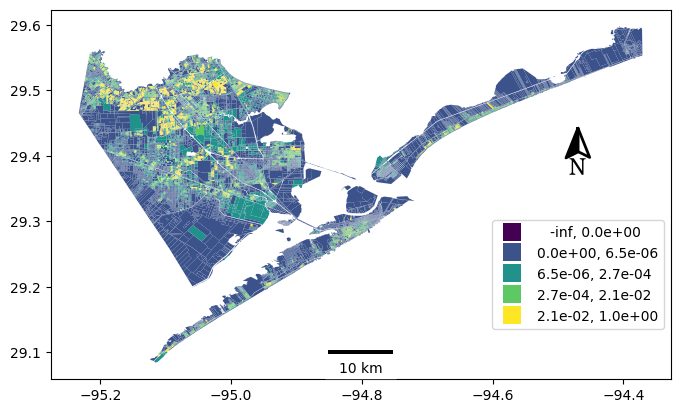

In [69]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1)
#Geodata0_random_count['VAL19IMP_int']  = np.round(Geodata0_random_count['VAL19IMP'] / 1000 )
Geodata.plot( column = 'predprobs', 
                #scheme = "Quantiles", k = 10,
                scheme="user_defined", k = 5,
                classification_kwds={'bins':[ 0, 6.55*10**(-6), 2.67*10**(-4), 0.0213]},
                legend=True, ax = ax, cmap = 'viridis',     
                edgecolor = "gray",  linewidth = 0.0 ,
                legend_kwds = {'loc':'upper right', 
                                'bbox_to_anchor':(1.0, 0.45), 
                                'fmt':'{:.1e}',
                                'markerscale':1.26, 
                                'title_fontsize':'large', 
                                'fontsize':'medium'}
                )
leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("")
#formatter = ScalarFormatter(useMathText=True)
#formatter.set_scientific(True)
#formatter.set_powerlimits((-3, 3))
#cax.yaxis.set_major_formatter(formatter)

# Set markers to square shape
x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.15) )
#ax.set_title('', fontsize= 28)
ax.set_axis_on()


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_16120/713553304.py:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for ea in leg1.legendHandles:


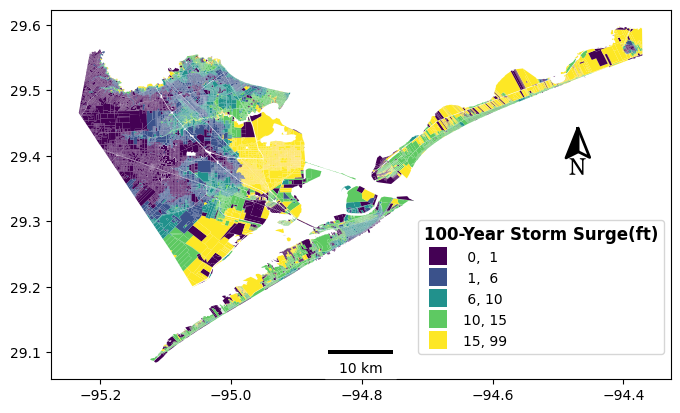

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)
#Geodata0_random_count['VAL19IMP_int']  = np.round(Geodata0_random_count['VAL19IMP'] / 1000 )
Geodata.plot( column = 'Cate4', 
                scheme = "Quantiles", k = 5,
                #scheme="user_defined", k = 5,
                #classification_kwds={'bins':[ 0, 6.55*10**(-6), 2.67*10**(-4), 0.0213]},
                legend=True, ax = ax, cmap = 'viridis',     
                edgecolor = "gray",  linewidth = 0.0 ,
                legend_kwds = {'loc':'upper right', 
                                'bbox_to_anchor':(1.0, 0.45), 
                                'fmt':'{:.0f}',
                                'markerscale':1.26, 
                                'title_fontsize':'large', 
                                'fontsize':'medium'}
                )
leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("")
# Set markers to square shape
legend = ax.get_legend()
legend.set_title( "100-Year Storm Surge(ft)" , prop={'size' : 12, 'weight':'bold'})
leg1._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.15) )
#ax.set_title('', fontsize= 28)
ax.set_axis_on()


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_16120/2572626649.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for ea in leg1.legendHandles:


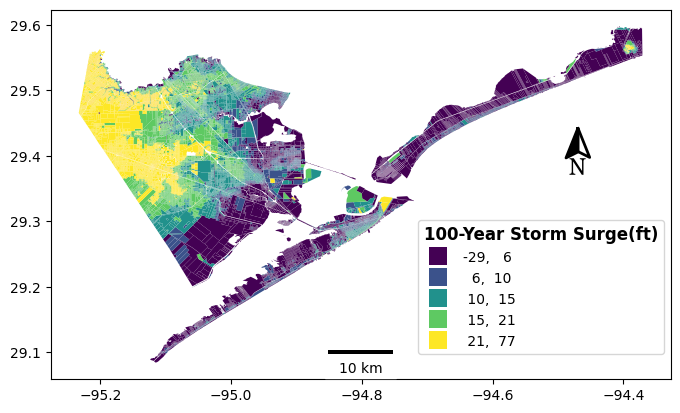

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)
#Geodata['floodHi']  = Geodata.apply(lambda x: 15.2229 + 0.6172 * x['vDEM'] - 0.7917 * x['logdit'], axis = 1)
Geodata['floodHi']  = Geodata.apply(lambda x: 3.451/ 0.3048 - x['DEM'] if 3.451/ 0.3048 > x['DEM'] else 0, axis = 1)
Geodata['diff']  =  Geodata.apply( lambda x:  x['Cate4'] - x['floodHi'] if x['Cate4'] > x['floodHi'] else 0, axis = 1 )
Geodata['vDEM']  = Geodata.apply(lambda x: 3.451/ 0.3048 - x['DEM'] + x['diff'] if x['DEM'] < 3.62/ 0.3048 else 0, axis = 1)
Geodata['logdit']  = np.log( Geodata['WaterCoast'] ) 
#Geodata['floodHi']  = Geodata.apply(lambda x: 15.2229 + 0.6172 * x['vDEM'] - 0.7917 * x['logdit'], axis = 1)


Geodata.plot( column = 'DEM', 
                scheme = "Quantiles", k = 5,
                #scheme="user_defined", k = 5,
                #classification_kwds={'bins':[ 0, 6.55*10**(-6), 2.67*10**(-4), 0.0213]},
                legend=True, ax = ax, cmap = 'viridis',     
                edgecolor = "gray",  linewidth = 0.0 ,
                legend_kwds = {'loc':'upper right', 
                                'bbox_to_anchor':(1.0, 0.45), 
                                'fmt':'{:.0f}',
                                'markerscale':1.26, 
                                'title_fontsize':'large', 
                                'fontsize':'medium'}
                )
leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("")
# Set markers to square shape
legend = ax.get_legend()
legend.set_title( "100-Year Storm Surge(ft)" , prop={'size' : 12, 'weight':'bold'})
leg1._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.15) )
#ax.set_title('', fontsize= 28)
ax.set_axis_on()


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/mapclassify/classifiers.py:894: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/mapclassify/classifiers.py:926: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 - self.adcm / adam
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_16120/127926264.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for ea in leg1.legendHandles:


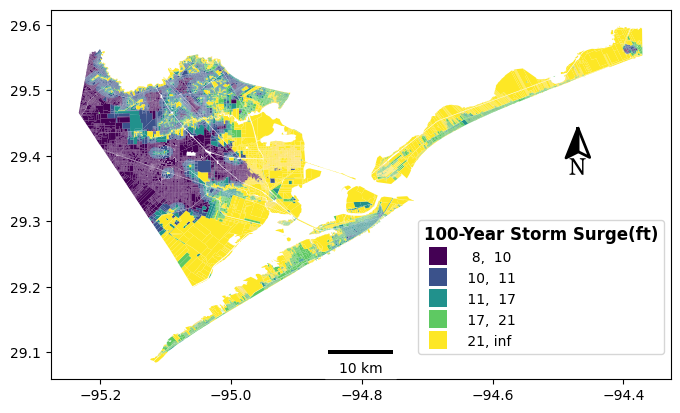

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)
#Geodata['floodHi']  = Geodata.apply(lambda x: 15.2229 + 0.6172 * x['vDEM'] - 0.7917 * x['logdit'], axis = 1)
Geodata['floodHi']  = Geodata.apply(lambda x: 3.451/ 0.3048 - x['DEM'] if 3.451/ 0.3048 > x['DEM'] else 0, axis = 1)
Geodata['diff']  =  Geodata.apply( lambda x:  x['Cate4'] - x['floodHi'] if x['Cate4'] > x['floodHi'] else 0, axis = 1 )
Geodata['vDEM']  = Geodata.apply(lambda x: 3.451/ 0.3048 - x['DEM'] + x['diff'] if x['DEM'] < 3.62/ 0.3048 else 0, axis = 1)
Geodata['logdit']  = np.log( Geodata['WaterCoast'] ) 
Geodata['floodHi']  = Geodata.apply(lambda x: 15.2229 + 0.6172 * x['vDEM'] - 0.7917 * x['logdit'], axis = 1)


Geodata.plot( column = 'floodHi', 
                scheme = "Quantiles", k = 5,
                #scheme="user_defined", k = 5,
                #classification_kwds={'bins':[ 0, 6.55*10**(-6), 2.67*10**(-4), 0.0213]},
                legend=True, ax = ax, cmap = 'viridis',     
                edgecolor = "gray",  linewidth = 0.0 ,
                legend_kwds = {'loc':'upper right', 
                                'bbox_to_anchor':(1.0, 0.45), 
                                'fmt':'{:.0f}',
                                'markerscale':1.26, 
                                'title_fontsize':'large', 
                                'fontsize':'medium'}
                )
leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("")
# Set markers to square shape
legend = ax.get_legend()
legend.set_title( "100-Year Storm Surge(ft)" , prop={'size' : 12, 'weight':'bold'})
leg1._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.15) )
#ax.set_title('', fontsize= 28)
ax.set_axis_on()


In [ ]:

###############################################################################
predYrs     = 2050
deltaY      = 10
initialYrs  = 2020
Geodata["LUC"]    = Geodata['LUCode20re']
#LandGrowth = 3276
ResidentialGrowth = (np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
                        (Geodata["LUCode20re"] < 6), "PArea" ]) - 
                     np.sum( Geodata.loc[ (Geodata["LUCode11re"] > 0) & 
                        (Geodata["LUCode11re"] < 6), "PArea" ]) )
#ResidentialGrowth = 39883108.19182694
predyears = range(initialYrs, predYrs, deltaY)
GeoNeighbors = {}
LandGrowth        = np.round( ResidentialGrowth )
###############################################################################
improvedValues  = [0]*len(Geodata)
changes         = [0]*len(Geodata)

for ykth in range( len( predyears ) ):
    """" update probs from gbdt"""
    yeark       = predyears[ ykth ]
    LandGrowth  = np.round( ResidentialGrowth )
    landuseProb = [0]*len(Geodata)
    NeighbiorLU = [0]*len(Geodata)
    landuseType = [0]*len(Geodata)
    print( yeark )
    idx = 0
    for index, row in Geodata.iterrows():
        if row['LUC']   <= 5 and row['LUC'] >= 0 and row['VAL19IMP'] > 0:
            landuseProb[idx]      +=  -1.0
            landuseType[idx]       =  row['LUC'] 
            improvedValues[idx]    =  row['VAL19IMP']
        elif "UW" in row['LANDUSE'] or row['LANDUSE'] == 0 :
            landuseProb[idx]      += -1.0 
            improvedValues[idx]    = row['VAL19IMP']
            landuseType[idx]       = 0
            row['LUC']             = 0
        elif (row['poicode'] == 2204 or row['poicode'] == 2082 or 
                  row['poicode'] == 2081) :
            landuseProb[idx]       = 0.0
            landuseType[idx]       = row['LUCode11re']  
            improvedValues[idx]    = row['VAL19IMP'] 
        elif row['parkigcode'] > 0 :
            landuseProb[idx]       = 0.0 
            improvedValues[idx]    = row['VAL19IMP']
            landuseType[idx]       =  row['LUC'] 
        elif row['watercode'] > 0 :
            landuseProb[idx]       = 0.0 
            improvedValues[idx]    = row['VAL19IMP']
            landuseType[idx]       =  row['LUC']    
        elif row['LUC']   != row['LUCode20re'] :
            landuseProb[idx]      +=  -1.0 
            landuseType[idx]       =  row['LUC'] 
            improvedValues[idx]    =  row['VAL19IMP']    
        else:
            if row['LUC'] > 0 and row['LUC'] < 5:
                print("error ", row['LUC'])
            landuseProb[idx]  = row['predprobs']
            if row['predLU'] == 0:
                maxlu         = 1
                print("Error !!!!!! ", row['predLU'] , " ", row['predprobs'])
            else:
                maxlu         = row['predLU']
            impvi = np.random.normal(159961.40, 2543.65) +\
                    np.random.normal(158.84, 55.61) * row["PArea"]                 
            landuseType[idx]       =  maxlu
            improvedValues[idx]    =  impvi 
        if ykth == 0 :
            if row['LUC']  <= 0 :
                improvedValues[idx]    = row['VAL19IMP']
                landuseType[idx]       = 0
                landuseProb[idx]       = 0.0
                #LandGrowth = LandGrowth + row['PArea']
                #if row['LUC']   <= 5 and row['LUC'] > 0:
                #    LandGrowth = LandGrowth + row['PArea']
                row['LUC']             = 0
            elif ( row['floodzones'] in [3, 10] and row['CoastDist'] < 2000  ) :
                if ( ( row['Risk'] + row["Insurance"] ) * 22.8 > row['VAL19TOT'] and 
                        row['VAL19TOT'] < 275000 ):
                    landuseProb[idx]       = 1.0
                    improvedValues[idx]    = row['VAL19IMP']
                    landuseType[idx]       = 0
                    #LandGrowth = LandGrowth + row['PArea']
                    #if row['LUC']   <= 5 and row['LUC'] > 0:
                    LandGrowth = LandGrowth + row['PArea']
                    row['LUC']             = 0     
                    #print("year0  buyout")
                # else:
                #     print( row['Risk'], " ", row['VAL19IMP'] )
        idx = idx + 1    
    Geodata["LUCprob"]  = landuseProb
    Geodata["LUCtype"]  = landuseType
    Geodata["ImproVal"] = improvedValues    
    #Geodata["LUC"]      = landuse
    Geodata.sort_values("LUCprob", ascending=False, inplace = True)
    Geodata["rank"] = Geodata.reset_index().index +1
    Geodata["PAreaCum"] = Geodata["PArea"].cumsum()
    #Geodata[ ["LUCode11re", "PArea", "PAreaCum"] ]
    lengthi = Geodata["PAreaCum"].searchsorted(LandGrowth, side='right') + 1
    temnlu = len( Geodata.loc[( Geodata["LUC"] > 0 ) & (Geodata["LUC"] < 6)] )
    #print( "length of PArea", lengthi )
    print( "Area ", Geodata.loc[ Geodata["rank"] < lengthi, "PArea"].sum() )
    #break
    results1 = []
    results2 = []
    for index, row in Geodata.iterrows():
        if row["rank"] < lengthi:
            if row["LUC"] != 0:
                results1.append( row["LUCtype"] )
                #if row["LUCtype"] == 0:
                    #print("LUCtype more buyout")
            else:
                results1.append( 0 ) 
                #print("one more buyout")
        else:
            results1.append( row["LUC"] )
        
        if row['LUC']   <= 5 and row['LUC'] >= 1 and row["ImproVal"] == 0:
            impvi = np.random.normal(159961.40, 2543.65) +\
                    np.random.normal(158.84, 55.61) * row["PArea"]     
            if impvi == 0:
                print( "Improvement value error1 ", row['VAL19IMP'] )
            results2.append( impvi )
        else:
            results2.append( row["ImproVal"] )
    # Geodata.loc[ Geodata["rank"] < lengthi, "LUC"]      = Geodata.loc[ Geodata["rank"] < lengthi, "LUCtype"]
    # Geodata.loc[ Geodata["rank"] < lengthi, "VAL19IMP"] = Geodata.loc[ Geodata["rank"] < lengthi, "ImproVal"]
    Geodata['LUC']      = results1
    Geodata['VAL19IMP'] = results2
    #print( len( Geodata.loc[( Geodata["LUC"] > 0 ) & (Geodata["LUC"] < 6)] ) )
    print( "# parcels diff ", len( Geodata.loc[( Geodata["LUC"] > 0 ) & 
                                               (Geodata["LUC"] < 6)] ) - temnlu )
    #print( "Land use 2020 ", Geodata.LUCode20re.value_counts(ascending=True) )
    #print( "Land use prediction 2020 ", Geodata.LUC.value_counts(ascending=True) )


# Geodata.loc[ ( Geodata['floodzones'] == 10 ) & 
#              ( Geodata['LUC'].isin( [1,2,3] ) )  &
#              ( Geodata['CoastDist'] < 1000 ), "LUC"] = 0



In [ ]:


# print( "LU2020 ", np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
#                                (Geodata["LUCode20re"] < 6), "PArea" ] ), 
#           " LU Predict ", np.sum( Geodata.loc[ (Geodata["LUC"] > 0) & (Geodata["LUC"] < 6), 
#                                    "PArea" ]), " \ndifference ", 
#           np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
#                               (Geodata["LUCode20re"] < 6), "PArea" ] ) -\
#           np.sum( Geodata.loc[ (Geodata["LUC"] > 0) & (Geodata["LUC"] < 6), 
#                               "PArea" ])  )
###############################################################################
###############################################################################
Geodata4 = Geodata[  ['GEOID', 'NAME', 'ZIP', 'VAL19IMP', 'VAL19TOT', 
                      'Bldg_Area', 'Bldg_Value', 'H_ft', 'Year_Built', 
                      'PopTot', 'TotHisp', 'MedHHInc', 'TotAge65', 
                      'Unempolyme', 'BelPoverty', 'Minority', 
                      'DEM', 'DEMmhw' , 'Cate1', 'Cate2', 'Cate3',
                      'Cate4', 'Cate5', 'lu01','lu06','lu11', 'lu15', 'lu20',
                      'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist', 
                      'ShopDist', 'CoastDist', 'WetlatDist', 'Long', 'Lati',
                      'floodzones', 'buildDEM', 'PArea', 'TARGET_FID', 
                      'NEIGHBORS', 'poicode', 'poiclass', 'poiname', 
                      'watercode', 'waterclass', 'watername', 'parkigcode', 
                      'parkigclas', 'parkigname', 'rddist', 'rddens', 
                      'slope_mhw', 'geometry',  'visit_counts', 'LUCode01re', 
                      'LUCode06re', 'LUCode11re', 'LUCode15re', 'LUCode20re', 
                      'CBR', 'CBRStd','NumStories','FoundationType',
                      'FirstFloorHt', 'Area','ContentCost','BldgDamageFnID', 
                      'YEARBUILT', 'DamageCate1', 'DamageCate2', 'DamageCate3', 
                      'DamageCate4', 'DamageCate5', 'geofid', 'Risk', 'NN1', 'predprobs', 
                      'LUC', 'ImproVal']  ]


#Geodata4 = Geodata4.set_crs( epsg= 2278 )
Geodata4 = gpd.GeoDataFrame( Geodata4 , geometry = 'geometry', crs="EPSG:4326")


Geodata4.to_file(filename= r'outputs/ParcelGC_LUC_sce2.shp',
            driver='ESRI Shapefile')

###########################################
Geodata4.loc[ ( (Geodata4['LUC'] <= 5 ) & 
             ( Geodata4['LUC'] >= 1 ) & 
             ( Geodata4['VAL19IMP'] == 0 ) ), 'VAL19IMP' ]

###############################################################################
###############################################################################


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_14557/647630755.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, _ = ax.get_legend_handles_labels()


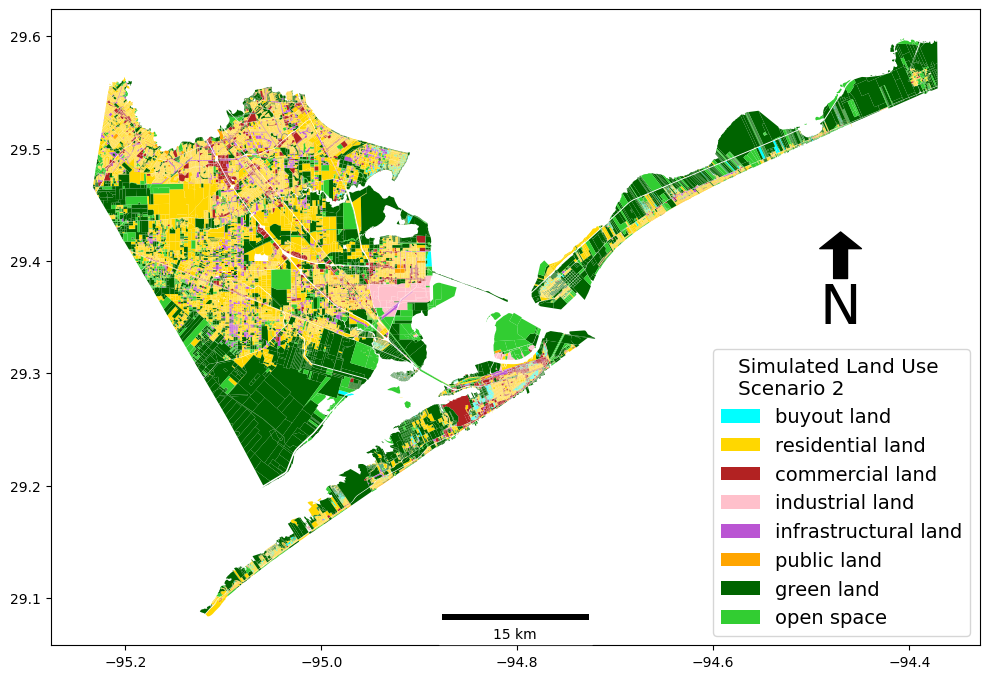

In [16]:

color_mapping = { 0: "aqua", 1: "gold", 2: "firebrick",
                  3: "pink", 4: "mediumorchid", 5: "orange", 
                  6: "darkgreen", 7 : "limegreen"}


label_mapping = { 0: "buyout land", 1: "residential land",
                  2: "commercial land", 3: "industrial land", 
                  4: "infrastructural land", 5: "public land",
                  6: "green land", 7 : "open space"}

Geodata["Colors"] = Geodata["LUC"].map(color_mapping)
Geodata["LUName"] = Geodata["LUC"].map(label_mapping)

new_df2  = Geodata.to_crs(epsg= 4326)

#################################################################################

fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in new_df2.groupby('LUC'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.plot(color=color, label= labeli ,
              ax=ax, linewidth= 0.01,
              markersize = 20, legend=True)
    pmarks.append(Patch(facecolor=color, label=labeli))


#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[*handles,*pmarks],
          title="Simulated Land Use \nScenario 2",
          title_fontsize='x-large', 
          loc='lower right',
          fontsize= 14,
          frameon=True)

x, y, arrow_length = 0.85, 0.65, 0.12
ax.annotate('N', xy=(x,y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='k', width=10, headwidth=30),
                va='center',ha='center', fontsize=40,
                xycoords= ax.transAxes)


ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
# ctx.add_basemap(ax ,
#                 source='https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
#                 zoom=8)
#ctx.add_basemap(ax ,source= ctx.providers.Stamen.TonerLite)
plt.tight_layout()
plt.savefig('../output_images/LandUse_sce2_test.png',dpi=300, bbox_inches='tight', pad_inches=0)

